2  Imports

In [1]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # for 3D plotting
import numpy as np 
import scipy as sp
from scipy import signal
import random
import os
import math
import itertools
from IPython.display import display_html


import gesturerec.utility as grutils
import gesturerec.data as grdata
import gesturerec.vis as grvis

from gesturerec.data import SensorData
from gesturerec.data import GestureSet

# Scikit-learn stuff
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, StratifiedKFold

# https://pandas.pydata.org/
import pandas as pd

# https://seaborn.pydata.org/
import seaborn as sns

3  Utility functions

In [2]:
def display_tables_side_by_side(df1, df2, n = None, df1_caption = "Caption table 1", df2_caption = "Caption table 2"):
    '''Displays the two tables side-by-side'''
    
    if n is not None:
        df1 = df1.head(n)
        df2 = df2.head(n)
    
    # https://stackoverflow.com/a/50899244
    df1_styler = df1.style.set_table_attributes("style='display:inline; margin:10px'").set_caption(df1_caption)
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption(df2_caption)

    display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)
    
def print_folds(cross_validator, X, y_true, trial_indices):
    '''Prints out the k-fold splits'''
    fold_cnt = 0
    for train_index, test_index in cross_validator.split(X, y_true):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_true.iloc[train_index], y_true.iloc[test_index]
        print("TEST FOLD {}".format(fold_cnt))
        for i in test_index:
            print("\t{} {}".format(y_true[i], trial_indices[i]))
        fold_cnt += 1
        
def display_folds(cross_validator, X, y_true, trial_indices):
    map_fold_to_class_labels = dict()
    fold_cnt = 0
    for train_index, test_index in cross_validator.split(X, y_true):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_true.iloc[train_index], y_true.iloc[test_index]
        
        class_labels = []
        for i in test_index:
            class_labels.append(f"{y_true[i]} {trial_indices[i]}")
        
        map_fold_to_class_labels[f"Fold {fold_cnt}"] = class_labels
        fold_cnt += 1
    
    df = pd.DataFrame(map_fold_to_class_labels)
    display(df)


def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

def get_top_n_frequency_peaks(n, freqs, amplitudes, min_amplitude_threshold = None):
    ''' Finds the top N frequencies and returns a sorted list of tuples (freq, amplitudes) '''

    fft_peaks_indices, fft_peaks_props = sp.signal.find_peaks(amplitudes, height = min_amplitude_threshold)
    
    freqs_at_peaks = freqs[fft_peaks_indices]
    amplitudes_at_peaks = amplitudes[fft_peaks_indices]
    
    if n < len(amplitudes_at_peaks):
        ind = np.argpartition(amplitudes_at_peaks, -n)[-n:] # from https://stackoverflow.com/a/23734295
        ind_sorted_by_coef = ind[np.argsort(-amplitudes_at_peaks[ind])] # reverse sort indices
    else:
        ind_sorted_by_coef = np.argsort(-amplitudes_at_peaks)

    return_list = list(zip(freqs_at_peaks[ind_sorted_by_coef], amplitudes_at_peaks[ind_sorted_by_coef]))
    return return_list

map_marker_to_desc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}

plot_markers = ['o','v','^','<','>','s','p','P','*','h','X','D','d','|','_',0,1,2,3,4,5,6,7,8,9,10,'1','2','3','4',',']

def plot_feature_1d(gesture_set, extract_feature_func, title = None, use_random_y_jitter = True,
                   xlim = None):
    '''
    Plots the extracted feature on a 1-dimensional plot. We use a random y-jitter 
    to make the values more noticeable
    
    Parameters:
    
    gesture_set: the GestureSet class
    extract_feature_func: a "pointer" to a function that accepts a trial.accel object and returns an extracted feature
    title: the graph title
    use_random_y_jitter: provides a random y jitter to make it easier to see values
    xlim: set the x range of the graph
    '''
    markers = list(map_marker_to_desc.keys())
    random.Random(3).shuffle(markers)
    marker = itertools.cycle(markers)
    plt.figure(figsize=(12, 3))
    for gesture_name in selected_gesture_set.get_gesture_names_sorted():
        trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
        x = list(extract_feature_func(trial.accel) for trial in trials)
        y = None
        
        if use_random_y_jitter:
            y = np.random.rand(len(x))
        else:
            y = np.zeros(len(x))
        
        marker_sizes = [200] * len(x) # make the marker sizes larger
        plt.scatter(x, y, alpha=0.65, marker=next(marker), 
                    s = marker_sizes, label=gesture_name)
        
    plt.ylim((0,3))
    
    if xlim is not None:
        plt.xlim(xlim)
    
    if use_random_y_jitter:
        plt.ylabel("Ignore the y-axis")
        
    plt.legend(bbox_to_anchor=(1,1))   
    
    if title is None:
        title = f"1D plot of {extract_feature_func.__name__}"
    
    plt.title(title)
    plt.show()
    
def plot_feature_2d(gesture_set, extract_feature_func1, extract_feature_func2,
                    xlabel = "Feature 1", ylabel = "Feature 2",
                    title = None, xlim = None):
    '''
    Plots the two extracted features on a 2-dimensional plot. 
    
    Parameters:
    
    gesture_set: the GestureSet class
    extract_feature_func1: a "pointer" to a function that accepts a trial.accel object and returns an extracted feature
    extract_feature_func2: a "pointer" to a function that accepts a trial.accel object and returns an extracted feature
    title: the graph title
    xlim: set the x range of the graph
    '''
    markers = list(map_marker_to_desc.keys())
    random.Random(3).shuffle(markers)
    marker = itertools.cycle(markers)
    plt.figure(figsize=(12, 5))
    for gesture_name in selected_gesture_set.get_gesture_names_sorted():
        trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
        x = list(extract_feature_func1(trial.accel) for trial in trials)
        y = list(extract_feature_func2(trial.accel) for trial in trials)

        
        marker_sizes = [200] * len(x) # make the marker sizes larger
        plt.scatter(x, y, alpha=0.65, marker=next(marker), 
                    s = marker_sizes, label=gesture_name)
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if xlim is not None:
        plt.xlim(xlim)
           
    plt.legend(bbox_to_anchor=(1,1))   
    
    plt.title(title)
    plt.show()
    
def plot_feature_3d(gesture_set, extract_feature_func1, extract_feature_func2,
                    extract_feature_func3, xlabel = "Feature 1", ylabel = "Feature 2",
                    zlabel = "Feature 2", title = None, figsize=(12,9)):
    '''
    Plots the two extracted features on a 2-dimensional plot. 
    
    Parameters:
    
    gesture_set: the GestureSet class
    extract_feature_func1: a "pointer" to a function that accepts a trial.accel object and returns an extracted feature
    extract_feature_func2: a "pointer" to a function that accepts a trial.accel object and returns an extracted feature
    extract_feature_func3: a "pointer" to a function that accepts a trial.accel object and returns an extracted feature
    title: the graph title
    xlim: set the x range of the graph
    '''
    markers = list(map_marker_to_desc.keys())
    random.Random(3).shuffle(markers)
    marker = itertools.cycle(markers)
    fig = plt.figure(figsize=figsize)
    ax = Axes3D(fig)
    for gesture_name in selected_gesture_set.get_gesture_names_sorted():
        trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
        x = list(extract_feature_func1(trial.accel) for trial in trials)
        y = list(extract_feature_func2(trial.accel) for trial in trials)
        z = list(extract_feature_func2(trial.accel) for trial in trials)
        
        marker_sizes = [200] * len(x) # make the marker sizes larger
        ax.scatter(x, y, z, alpha=0.65, marker=next(marker), 
                    s = marker_sizes, label=gesture_name)
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
           
    ax.legend()   
    
    ax.set_title(title)
    return fig, ax

def plot_bar_graph(d, title=None, ylabel=None, xlabel=None):
    '''
    Plots a bar graph of of the values in d (with the keys as names)
    '''
    
    sorted_tuple_list = sorted(d.items(), key=lambda x: x[1])
    n_groups = len(d)

    sorted_keys = [] 
    sorted_values = [] 
    for k, v in sorted_tuple_list:
        sorted_keys.append(k)
        sorted_values.append(v)

    # create plot
    fig_height = max(n_groups * 0.5, 5)
    plt.figure(figsize=(12, fig_height))
    indices = np.arange(len(sorted_keys))

    plt.grid(zorder=0)
    bars = plt.barh(indices, sorted_values, alpha=0.8, color='b', zorder=3)
    
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.xlim(0, sorted_values[-1] * 1.1)
    plt.title(title)
    plt.yticks(indices, sorted_keys)
    
    for i, v in enumerate(sorted_values):
        plt.text(v + 0.01, i, "{:0.2f}".format(v), color='black', fontweight='bold')
    

    plt.tight_layout()
    plt.show()
    
def plot_signals(gesture_set, signal_var_names = ['x', 'y', 'z']):
    '''Plots the gesture set as a grid given the signal_var_names'''
    num_rows = len(gesture_set.map_gestures_to_trials)
    num_cols = len(signal_var_names)
    row_height = 3.5
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, row_height * num_rows))
    fig.subplots_adjust(hspace=0.5)

    index = 0
    for row, gesture_name in enumerate(gesture_set.get_gesture_names_sorted()):
        gesture_trials = gesture_set.get_trials_for_gesture(gesture_name)

        for trial in gesture_trials:
            for col, signal_var_name in enumerate(signal_var_names):
                s = getattr(trial.accel, signal_var_name)       
                axes[row][col].plot(s, alpha=0.7, label=f"Trial {trial.trial_num}")

                axes[row][col].set_title(f"{gesture_name}: {signal_var_name}")
                axes[row][col].legend()

    fig.tight_layout(pad=2)

def plot_signals_aligned(gesture_set, signal_var_names = ['x', 'y', 'z'], title_fontsize=8):
    '''Aligns each signal using cross correlation and then plots them'''
    num_rows = len(gesture_set.map_gestures_to_trials)
    num_cols = len(signal_var_names)
    row_height = 3.5
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, row_height * num_rows))
    fig.subplots_adjust(hspace=0.5)

    index = 0
    for row, gesture_name in enumerate(gesture_set.get_gesture_names_sorted()):
        gesture_trials = gesture_set.get_trials_for_gesture(gesture_name)

        for col, signal_var_name in enumerate(signal_var_names):
            
            # Find the maximum length signal. We need this to pad all
            # signals to the same length (a requirement of cross correlation)
            signal_lengths = []
            for trial in gesture_trials:
                s = getattr(trial.accel, signal_var_name) 
                signal_lengths.append(len(s))
            max_trial_length = np.max(signal_lengths)
            
            # Actually pad the signals
            signals = []
            for trial in gesture_trials:
                s = getattr(trial.accel, signal_var_name) 
                
                padding_length = max_trial_length - len(s)
                if padding_length > 0:
                    pad_amount_left = (math.floor(padding_length/2.0))
                    pad_amount_right = (math.ceil(padding_length/2.0))
                    padded_s = np.pad(s, (pad_amount_left, pad_amount_right), mode = 'mean')
                    signals.append(padded_s)
                else:
                    signals.append(s)
            
            # Grab a signal to align everything to. We could more carefully choose
            # this signal to be the closest signal to the average aggregate... but this
            # should do for now
            golden_signal = signals[0] # the signal to align everything to
            
            # Align all the signals and store them in aligned_signals
            aligned_signals = [golden_signal]
            for i in range(1, len(signals)):
                a = golden_signal
                b = signals[i]
                correlate_result = np.correlate(a, b, 'full')
                best_correlation_index = np.argmax(correlate_result)
                shift_amount = (-len(a) + 1) + best_correlation_index
                b_shifted_mean_fill = shift_array(b, shift_amount, np.mean(b))
                aligned_signals.append(b_shifted_mean_fill)
            
            # Plot the aligned signals
            for signal_index, trial in enumerate(gesture_trials):
                s = aligned_signals[signal_index]
                axes[row][col].plot(s, alpha=0.7, label=f"Trial {trial.trial_num}")

                axes[row][col].set_title(f"Aligned {gesture_name}: {signal_var_name}", fontsize=title_fontsize)
                axes[row][col].legend()           

    fig.tight_layout(pad=2)
    
def shift_array(arr, shift_amount, fill_value = np.nan):
    '''Shifts the array either left or right by the shift_amount (which can be negative or positive)
     
       From: https://stackoverflow.com/a/42642326
    '''
    result = np.empty_like(arr)
    if shift_amount > 0:
        result[:shift_amount] = fill_value
        result[shift_amount:] = arr[:-shift_amount]
    elif shift_amount < 0:
        result[shift_amount:] = fill_value
        result[:shift_amount] = arr[-shift_amount:]
    else:
        result[:] = arr
    return result

4  Load the data

In [3]:
# Load the data
root_gesture_log_path = './GestureLogs'

print("Found the following gesture log sub-directories")
print(grutils.get_immediate_subdirectories(root_gesture_log_path))

gesture_log_paths = grutils.get_immediate_subdirectories(root_gesture_log_path)
map_gesture_sets = dict()
selected_gesture_set = None

for gesture_log_path in gesture_log_paths:
    path_to_gesture_log = os.path.join(root_gesture_log_path, gesture_log_path)
    print("Creating a GestureSet object for path '{}'".format(path_to_gesture_log))
    gesture_set = grdata.GestureSet(path_to_gesture_log)
    gesture_set.load()
    map_gesture_sets[gesture_set.name] = gesture_set

if selected_gesture_set is None:
    # Since we load multiple gesture sets and often want to just visualize and explore
    # one set, in particular, we set a selected_gesture_set variable here
    # Feel free to change this
    #selected_gesture_set = get_random_gesture_set(map_gesture_sets)
    selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "User")
    if selected_gesture_set is None:
        # if the selected gesture set is still None
        selected_gesture_set = grdata.get_random_gesture_set(map_gesture_sets);

print("The selected gesture set:", selected_gesture_set)

Found the following gesture log sub-directories
['Test10Gesture', 'Test1Gesture', 'Test2Gesture', 'Test3Gesture', 'Test5Gesture', 'Test6Gesture', 'Test7Gesture', 'Test8Gesture', 'Test9Gesture', 'UserGesture']
Creating a GestureSet object for path './GestureLogs\Test10Gesture'
Found 30 csv files in ./GestureLogs\Test10Gesture
Found 6 gestures
Found 5 trials for 'Clockwise'
Found 5 trials for 'Counter Clockwise'
Found 5 trials for 'Down'
Found 5 trials for 'Left'
Found 5 trials for 'Right'
Found 5 trials for 'Up'
Max trial length across all gesture is 'Counter Clockwise' Trial 0 with 260 sensor events.
Avg samples/sec across 30 sensor files: 73.5
Avg sample length across 30 sensor files: 2.4s

Creating a GestureSet object for path './GestureLogs\Test1Gesture'
Found 30 csv files in ./GestureLogs\Test1Gesture
Found 6 gestures
Found 5 trials for 'Clockwise'
Found 5 trials for 'Counter Clockwise'
Found 5 trials for 'Down'
Found 5 trials for 'Left'
Found 5 trials for 'Right'
Found 5 trials fo

In [4]:
print(f"We have {len(map_gesture_sets)} gesture sets:")
for gesture_set_name, gesture_set in map_gesture_sets.items():
    print(f" {gesture_set_name} with {len(gesture_set.get_all_trials())} trials")

# Feel free to change the selected_gesture_set. It's just a convenient variable
# to explore one gesture set at a time
print(f"The selected gesture set is: {selected_gesture_set.name}")

We have 10 gesture sets:
 Test10Gesture with 30 trials
 Test1Gesture with 30 trials
 Test2Gesture with 30 trials
 Test3Gesture with 30 trials
 Test5Gesture with 30 trials
 Test6Gesture with 30 trials
 Test7Gesture with 30 trials
 Test8Gesture with 30 trials
 Test9Gesture with 30 trials
 UserGesture with 30 trials
The selected gesture set is: UserGesture


5  Preprocess the data

In [5]:
def preprocess_signal(s):
    '''Preprocesses the signal'''
    
    # TODO: write your preprocessing code here. We'll do something very simple for now,
    
    mean_filter_window_size = 10
    processed_signal = np.convolve(s, 
                                   np.ones((mean_filter_window_size,))/mean_filter_window_size, 
                                   mode='valid')
    return processed_signal

def preprocess_trial(trial):
    '''Processess the given trial'''
    trial.accel.x_p = preprocess_signal(trial.accel.x)
    trial.accel.y_p = preprocess_signal(trial.accel.y)
    trial.accel.z_p = preprocess_signal(trial.accel.z)
    trial.accel.mag_p = preprocess_signal(trial.accel.mag)

for gesture_set in map_gesture_sets.values():
    for gesture_name, trials in gesture_set.map_gestures_to_trials.items():
        for trial in trials:
            preprocess_trial(trial)

6  Feature exploration

6.1  Time domain

6.1.1  Visualizing time-domain signals

6.1.1.1 Visualizing raw x, y, z, and mag

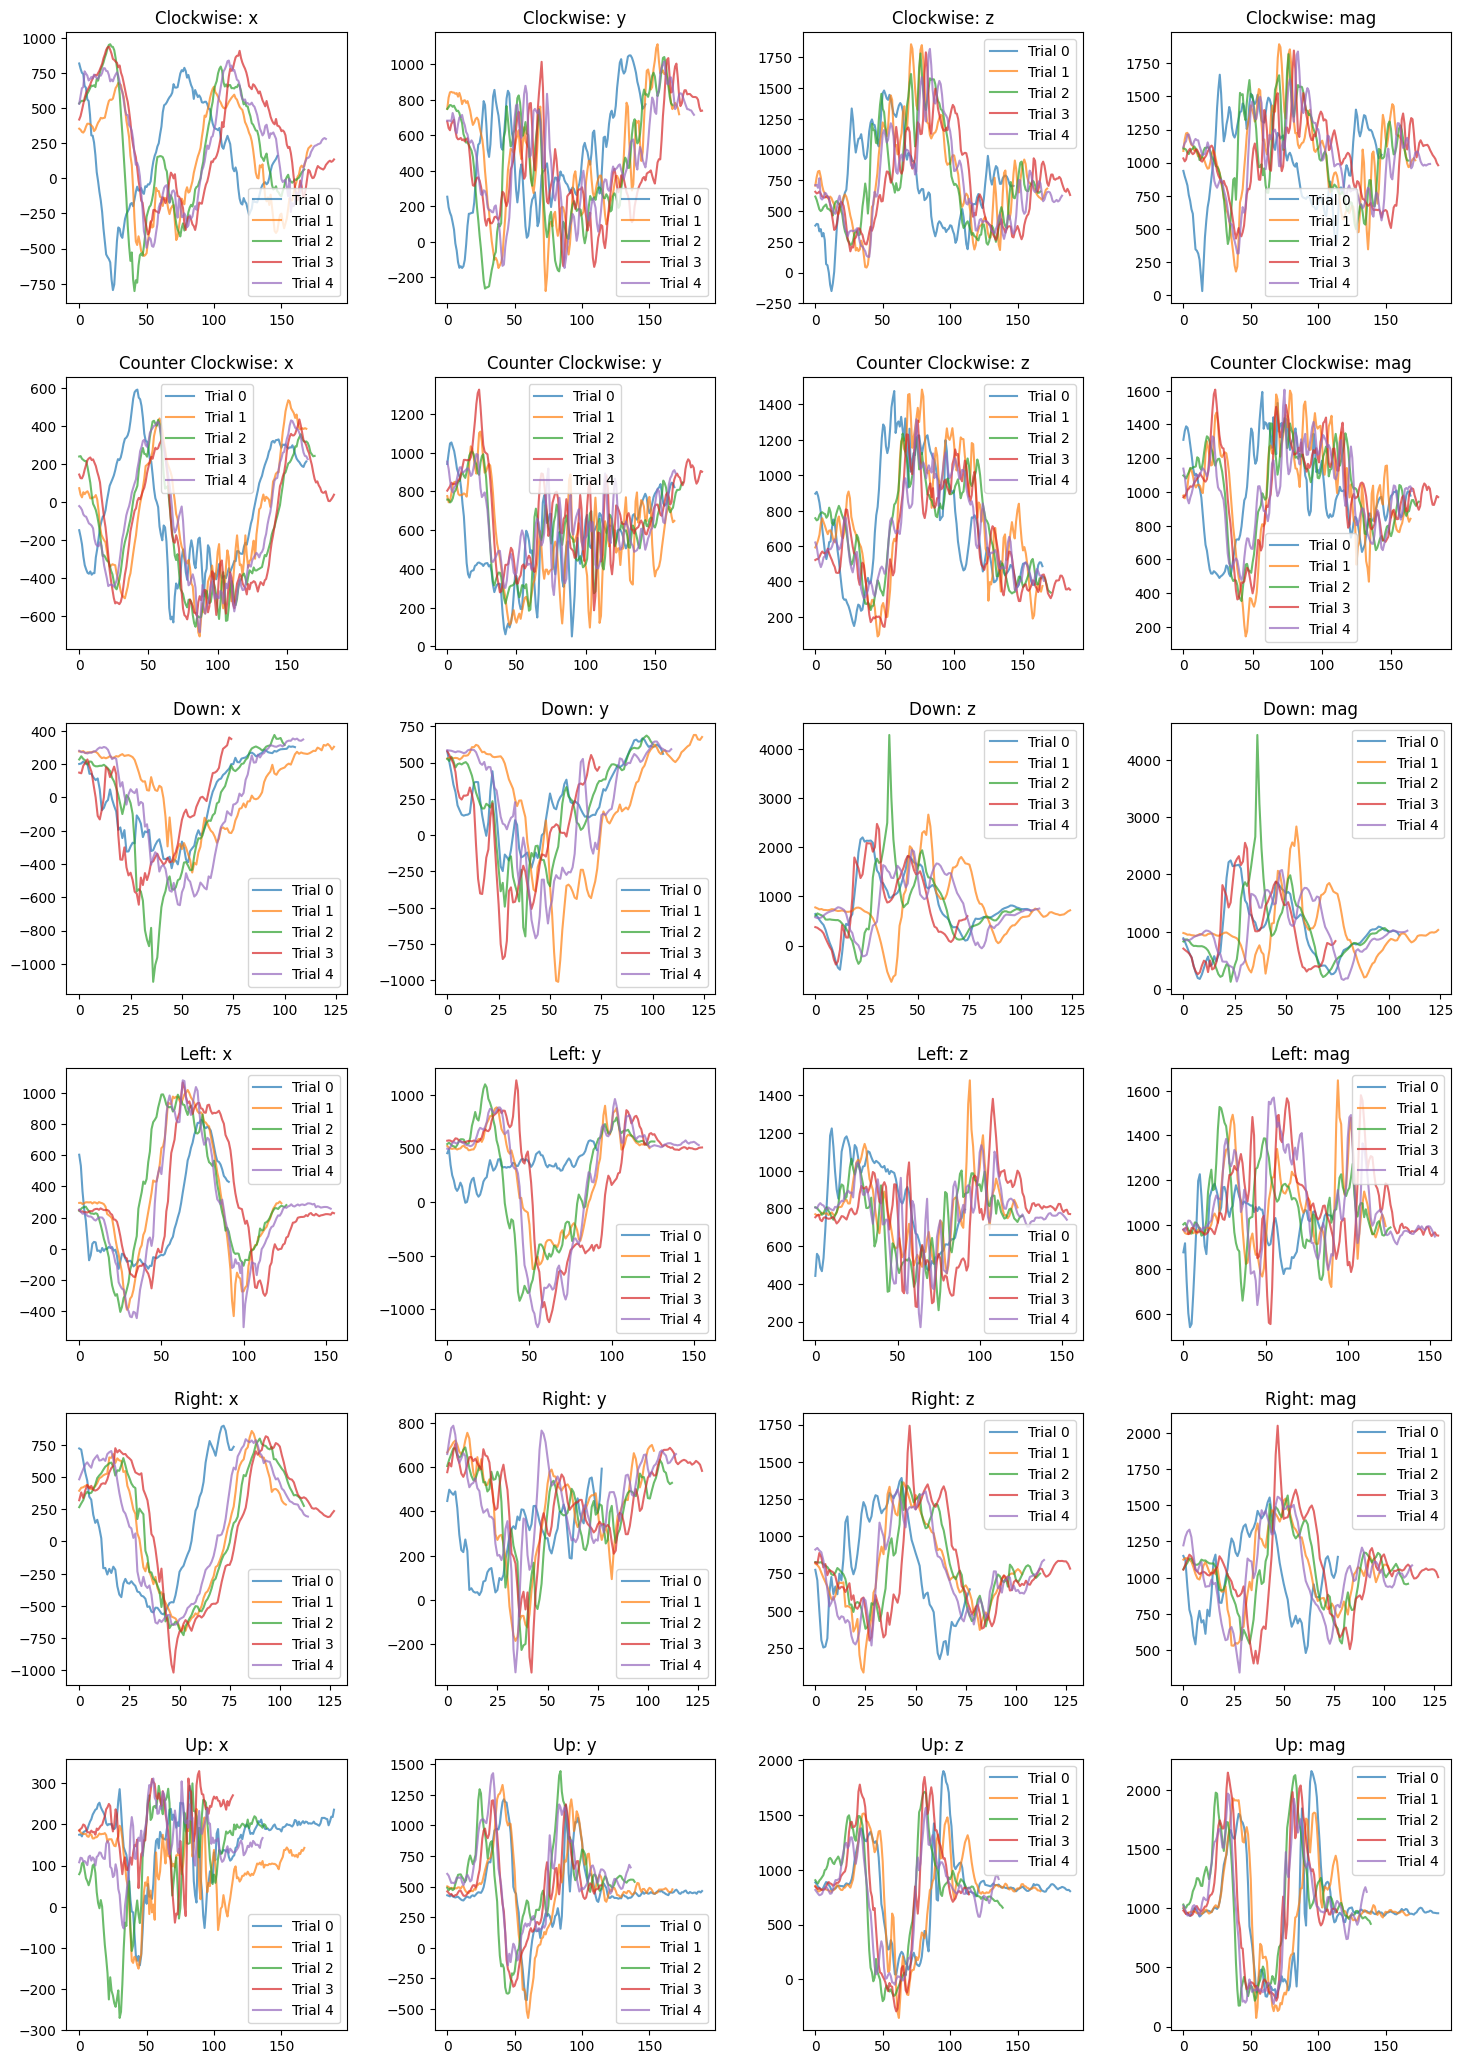

In [6]:
plot_signals(selected_gesture_set, ['x', 'y', 'z', 'mag'])

6.1.1.2 Visualizing aligned raw signals

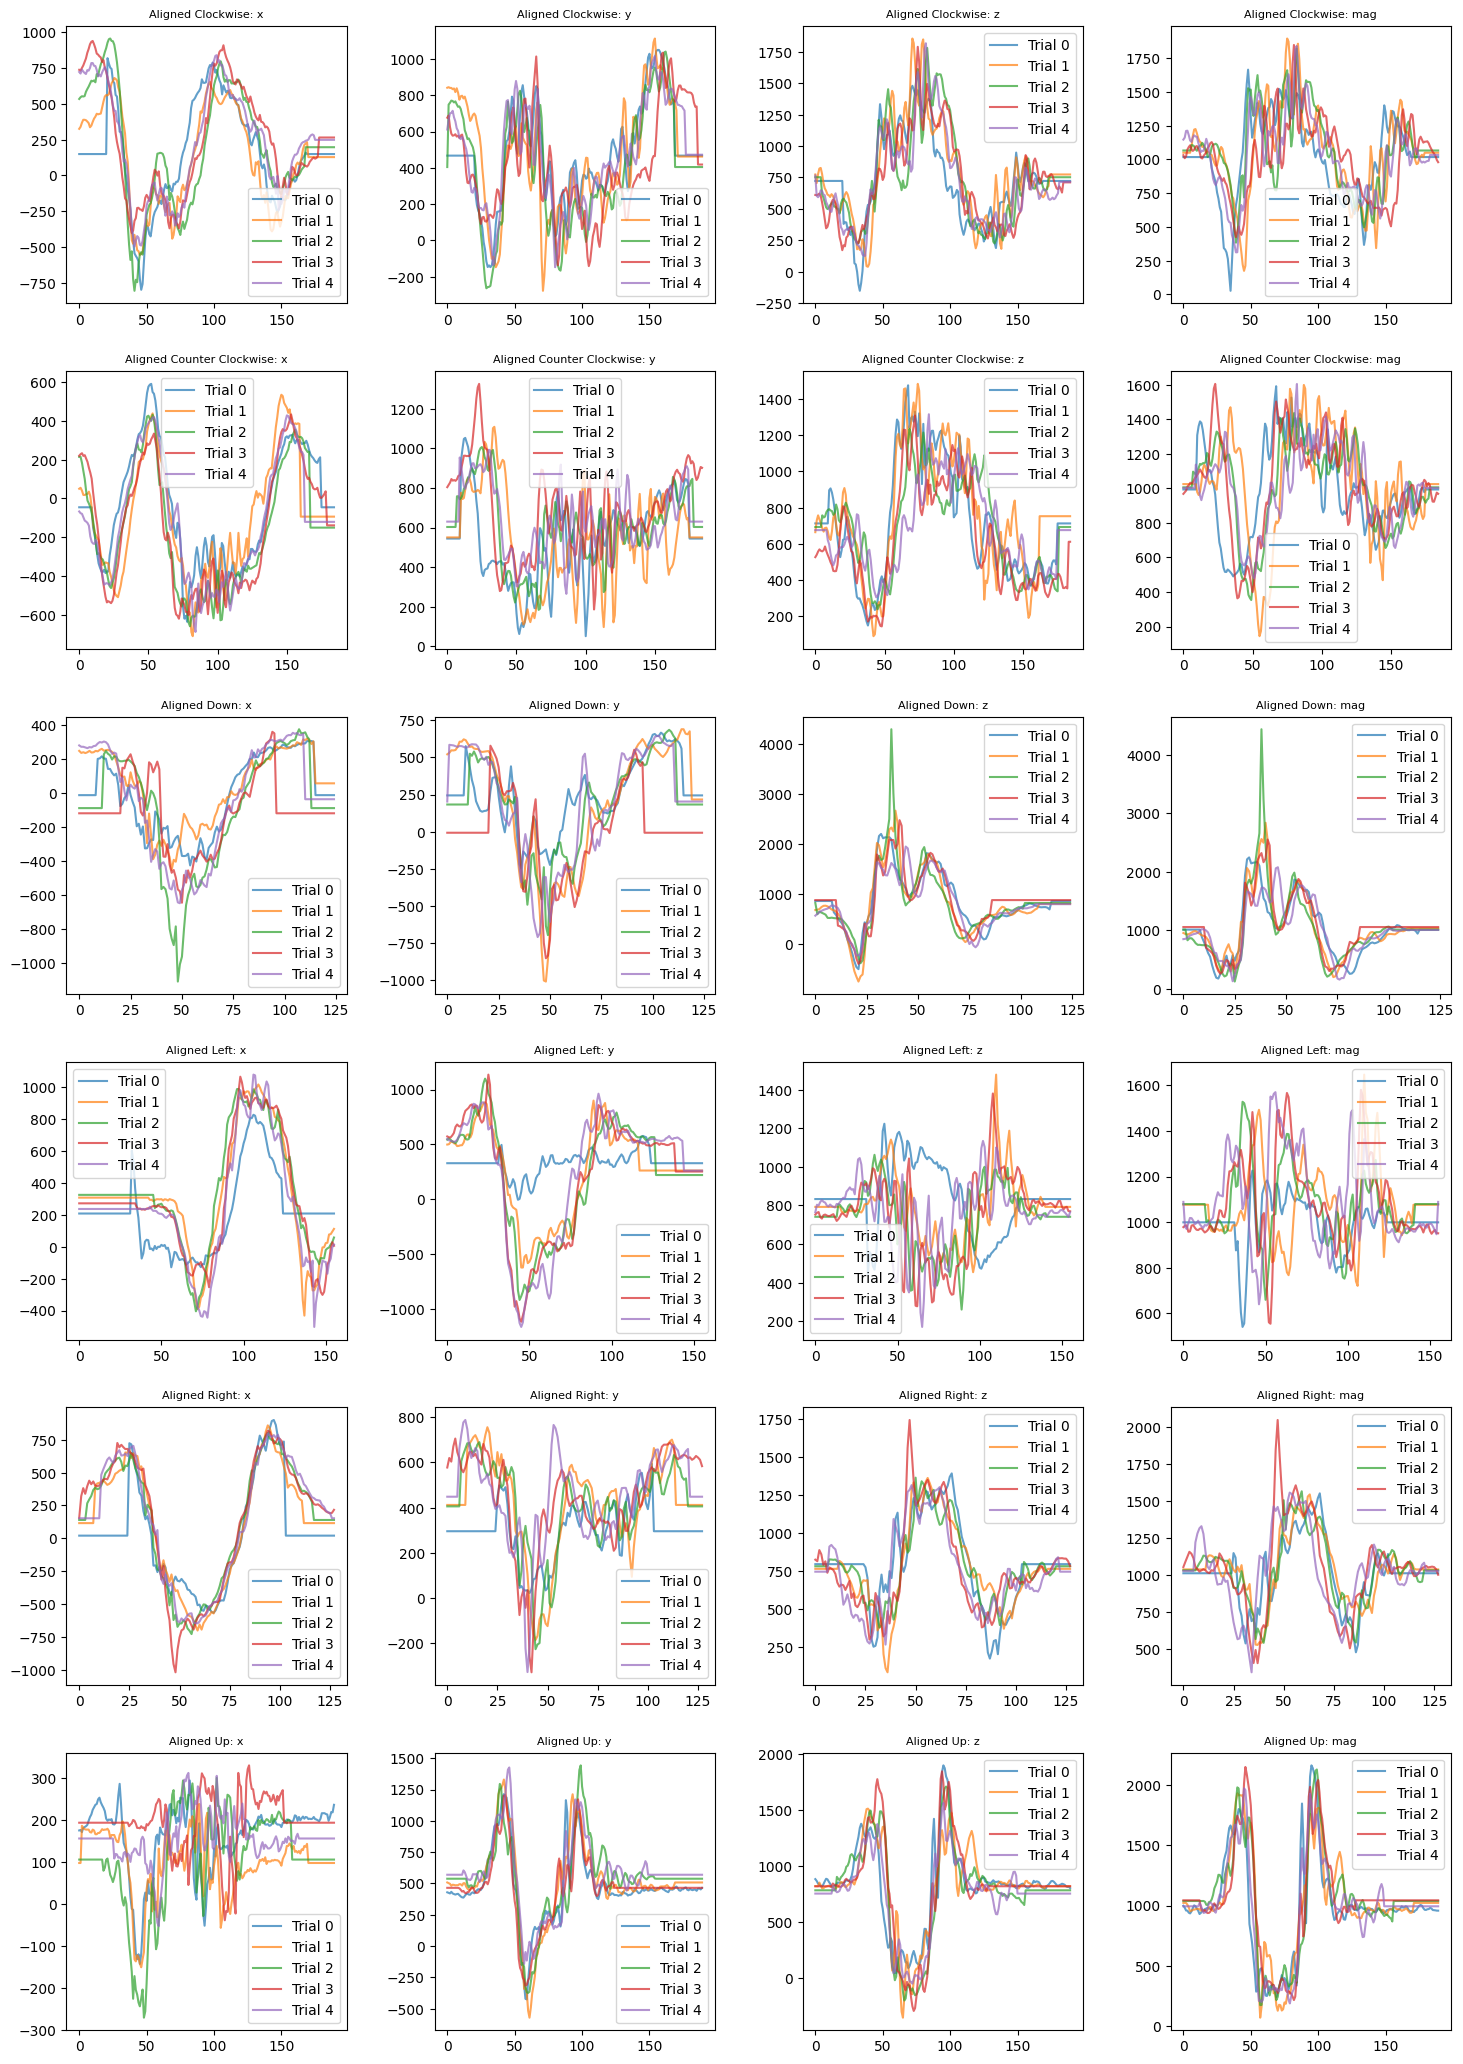

In [7]:
plot_signals_aligned(selected_gesture_set, ['x', 'y', 'z', 'mag'])

6.1.1.3 Visualizing processed x, y, z, and mag signals

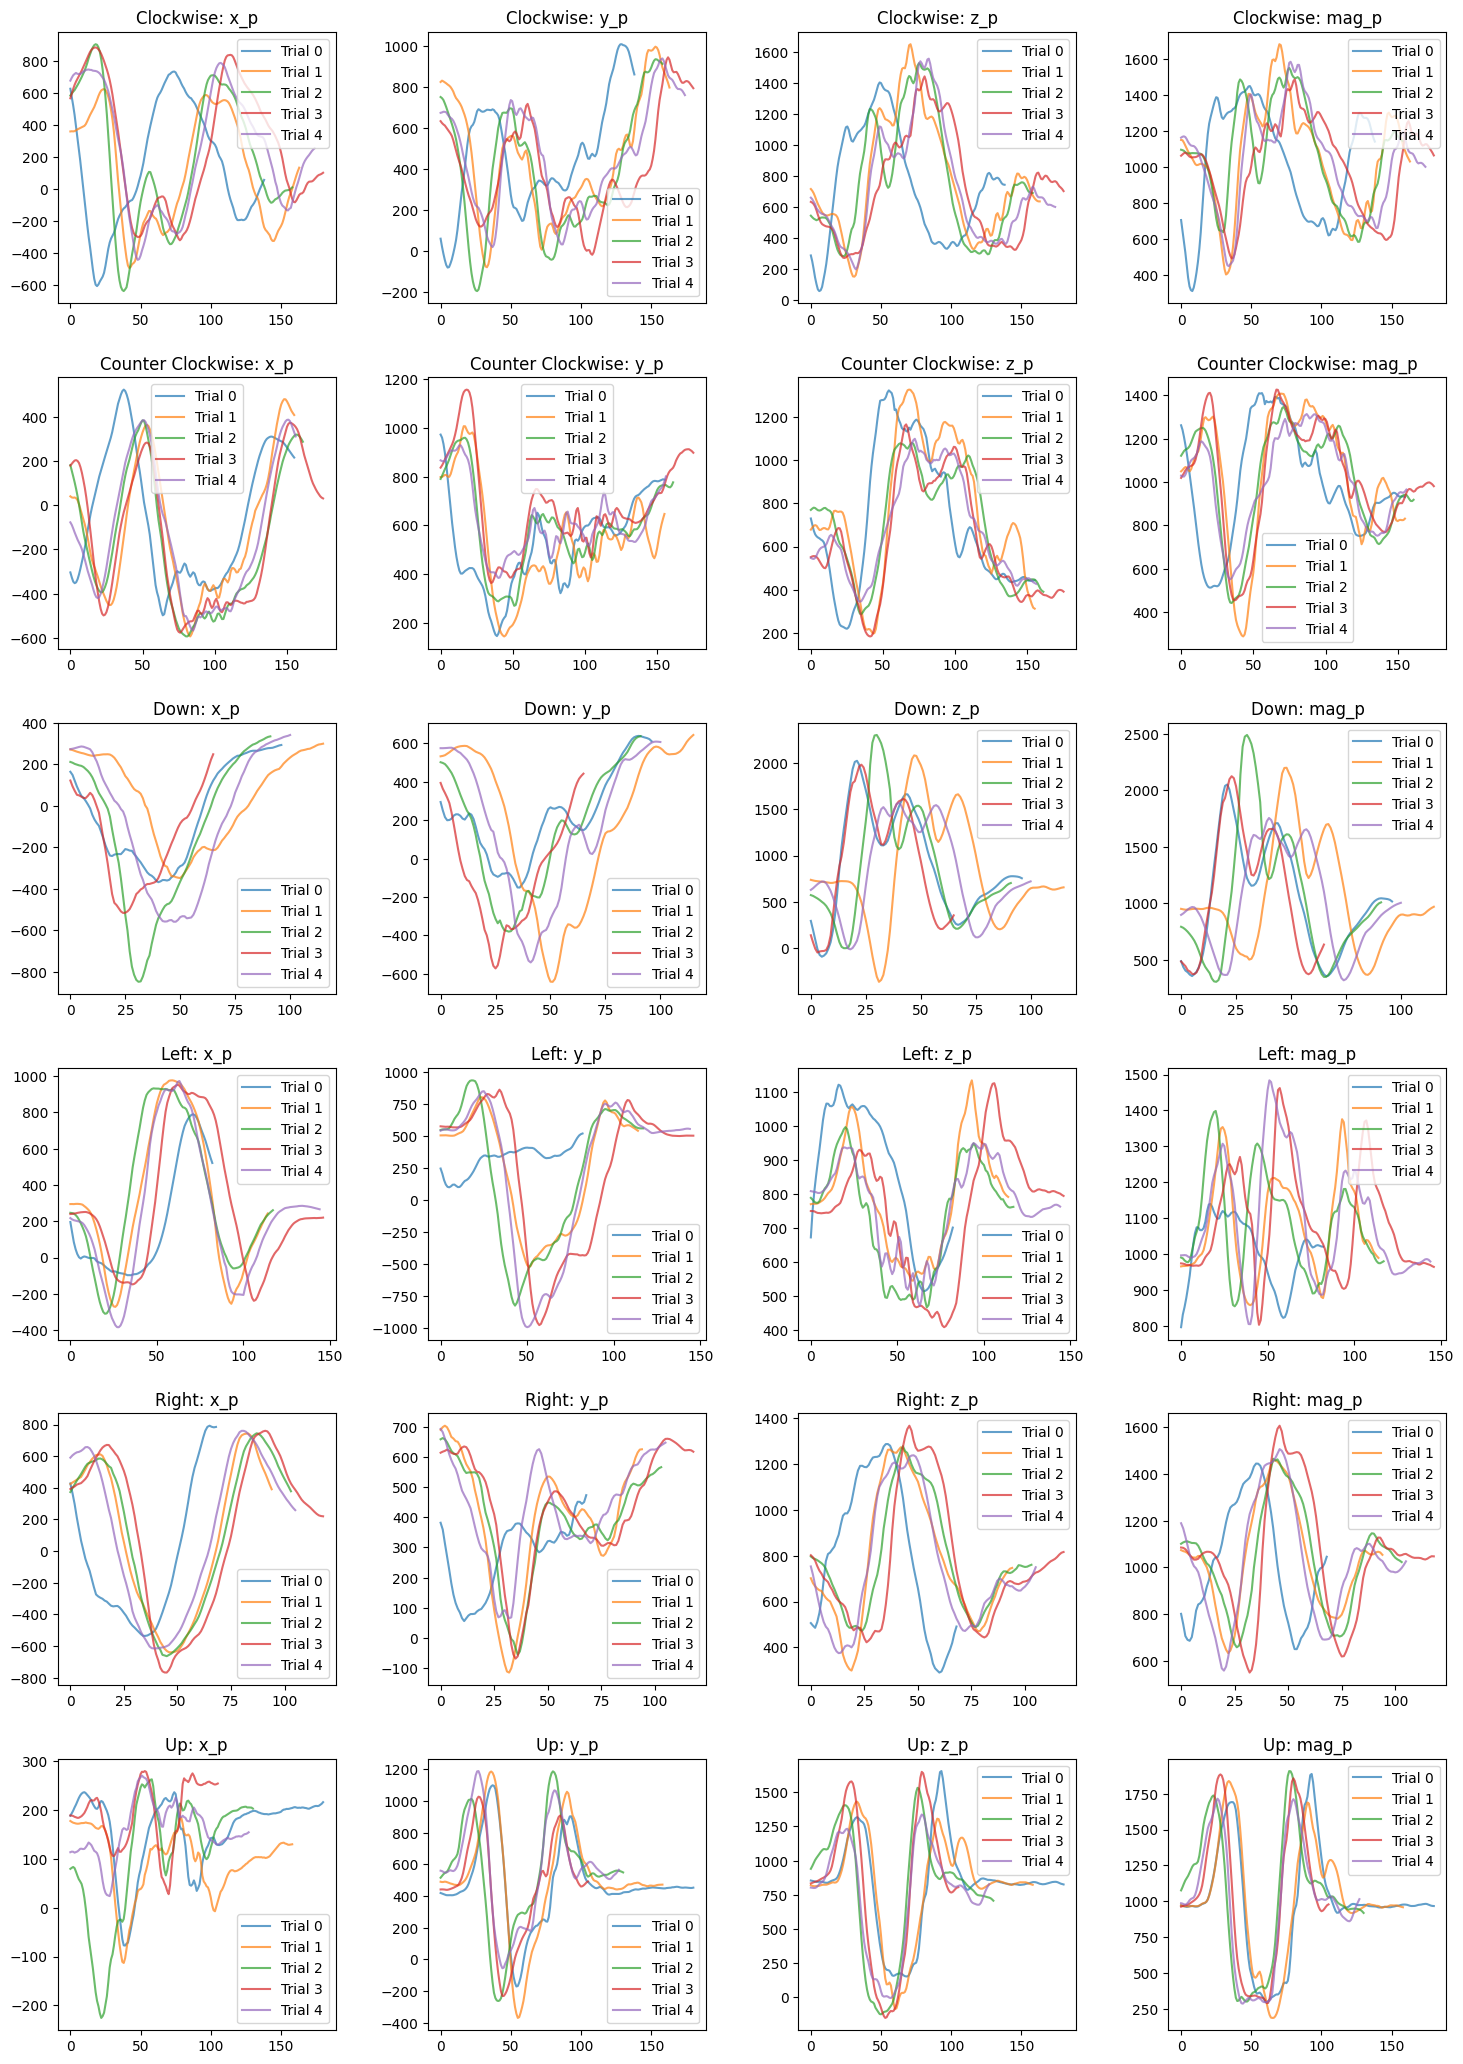

In [8]:
plot_signals(selected_gesture_set, ['x_p', 'y_p', 'z_p', 'mag_p'])

6.1.1.4 Visualizing aligned processed signals

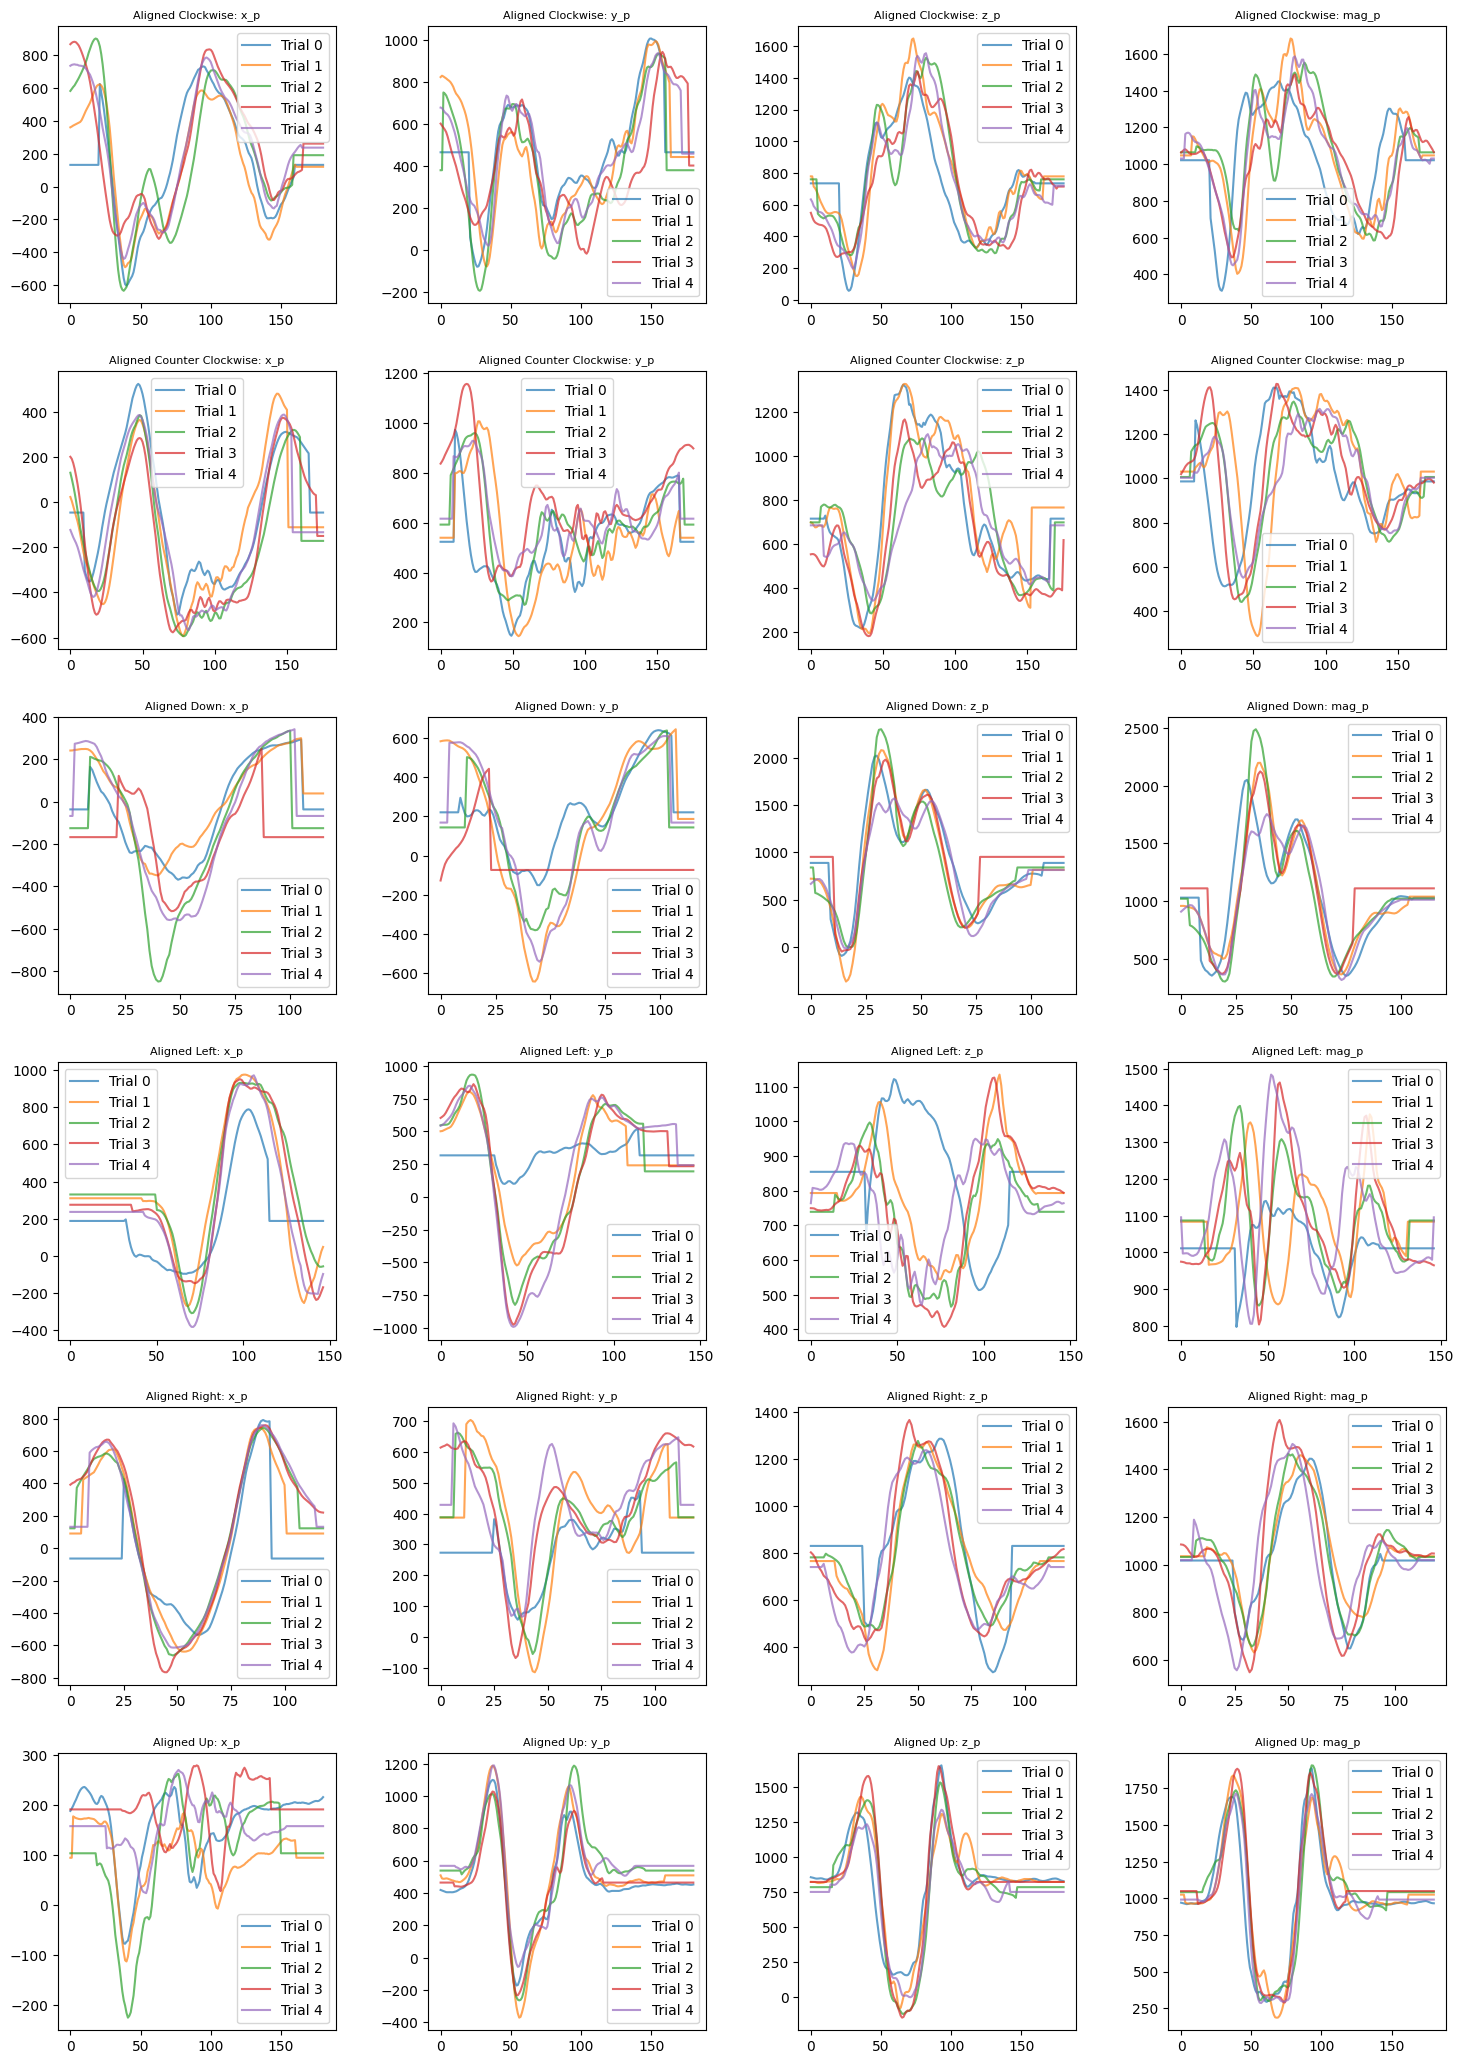

In [9]:
plot_signals_aligned(selected_gesture_set, ['x_p', 'y_p', 'z_p', 'mag_p'])

6.1.2  Extract and visualize time-domain features

6.1.2.1  Feature: standard deviation of accel mag

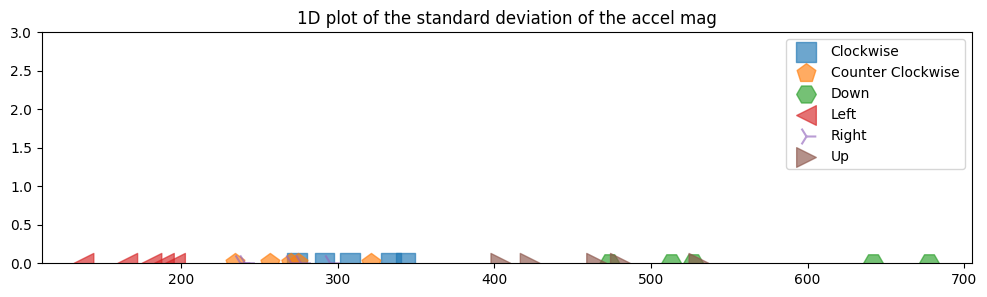

In [10]:

extract_feature_std_mag = lambda accel_trial: np.std(accel_trial.mag)

# def extract_feature_std_mag(accel_trial):
#    return np.std(accel_trial.mag)

# Plot the feature (but with no y-jitter)
graph_title = "1D plot of the standard deviation of the accel mag"
plot_feature_1d(selected_gesture_set, extract_feature_std_mag, 
                title = graph_title, use_random_y_jitter = False)

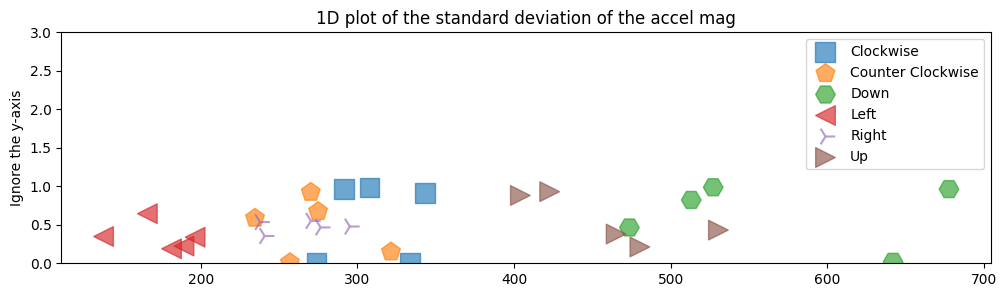

In [11]:
#To make it easier to see the 1-dimensional spacing, by default, we add in a random y-jitter
graph_title = "1D plot of the standard deviation of the accel mag"
plot_feature_1d(selected_gesture_set, extract_feature_std_mag, title = graph_title)

6.1.2.2  Feature: maximum accel mag

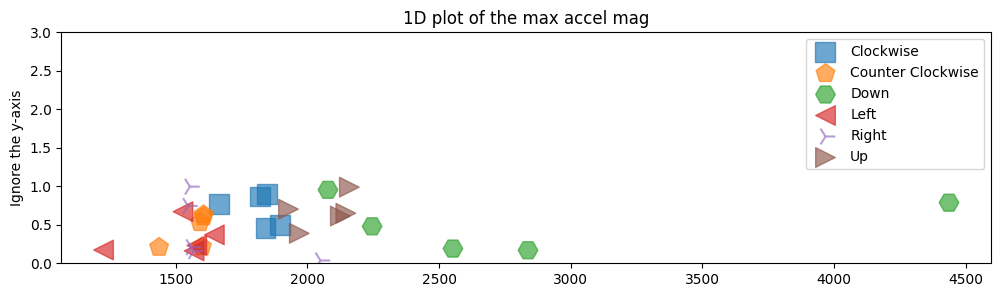

In [12]:
extract_feature_max_mag = lambda accel_trial: np.max(accel_trial.mag)
plot_feature_1d(selected_gesture_set, extract_feature_max_mag, 
                title = "1D plot of the max accel mag")

6.1.2.3  Feature: num peaks

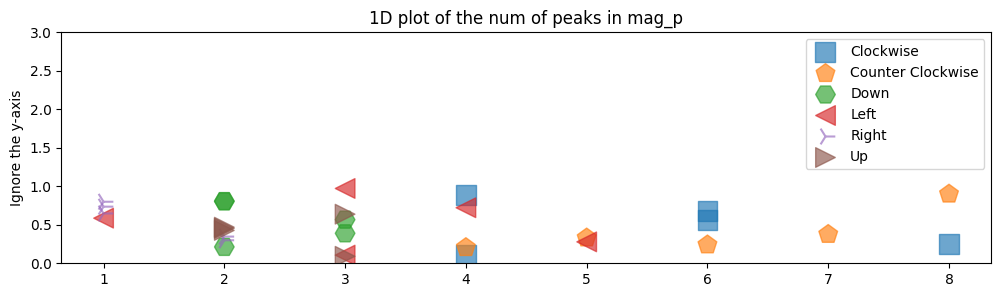

In [13]:
def extract_feature_num_peaks_mag_p(accel_trial):
    mag_p = sp.signal.detrend(accel_trial.mag_p)
    
    # height is the height of the peaks and distance is the minimum horizontal distance
    # (in samples) between peaks. Feel free to play with these thresholds
    peak_indices, peak_properties = sp.signal.find_peaks(mag_p, height=100, distance=5)
    return len(peak_indices)
    
plot_feature_1d(selected_gesture_set, extract_feature_num_peaks_mag_p, 
                title = "1D plot of the num of peaks in mag_p")

6.2  Frequency domain

6.2.1  Visualizing frequency information

IntProgress(value=0, max=12)

Selected gesture set: UserGesture


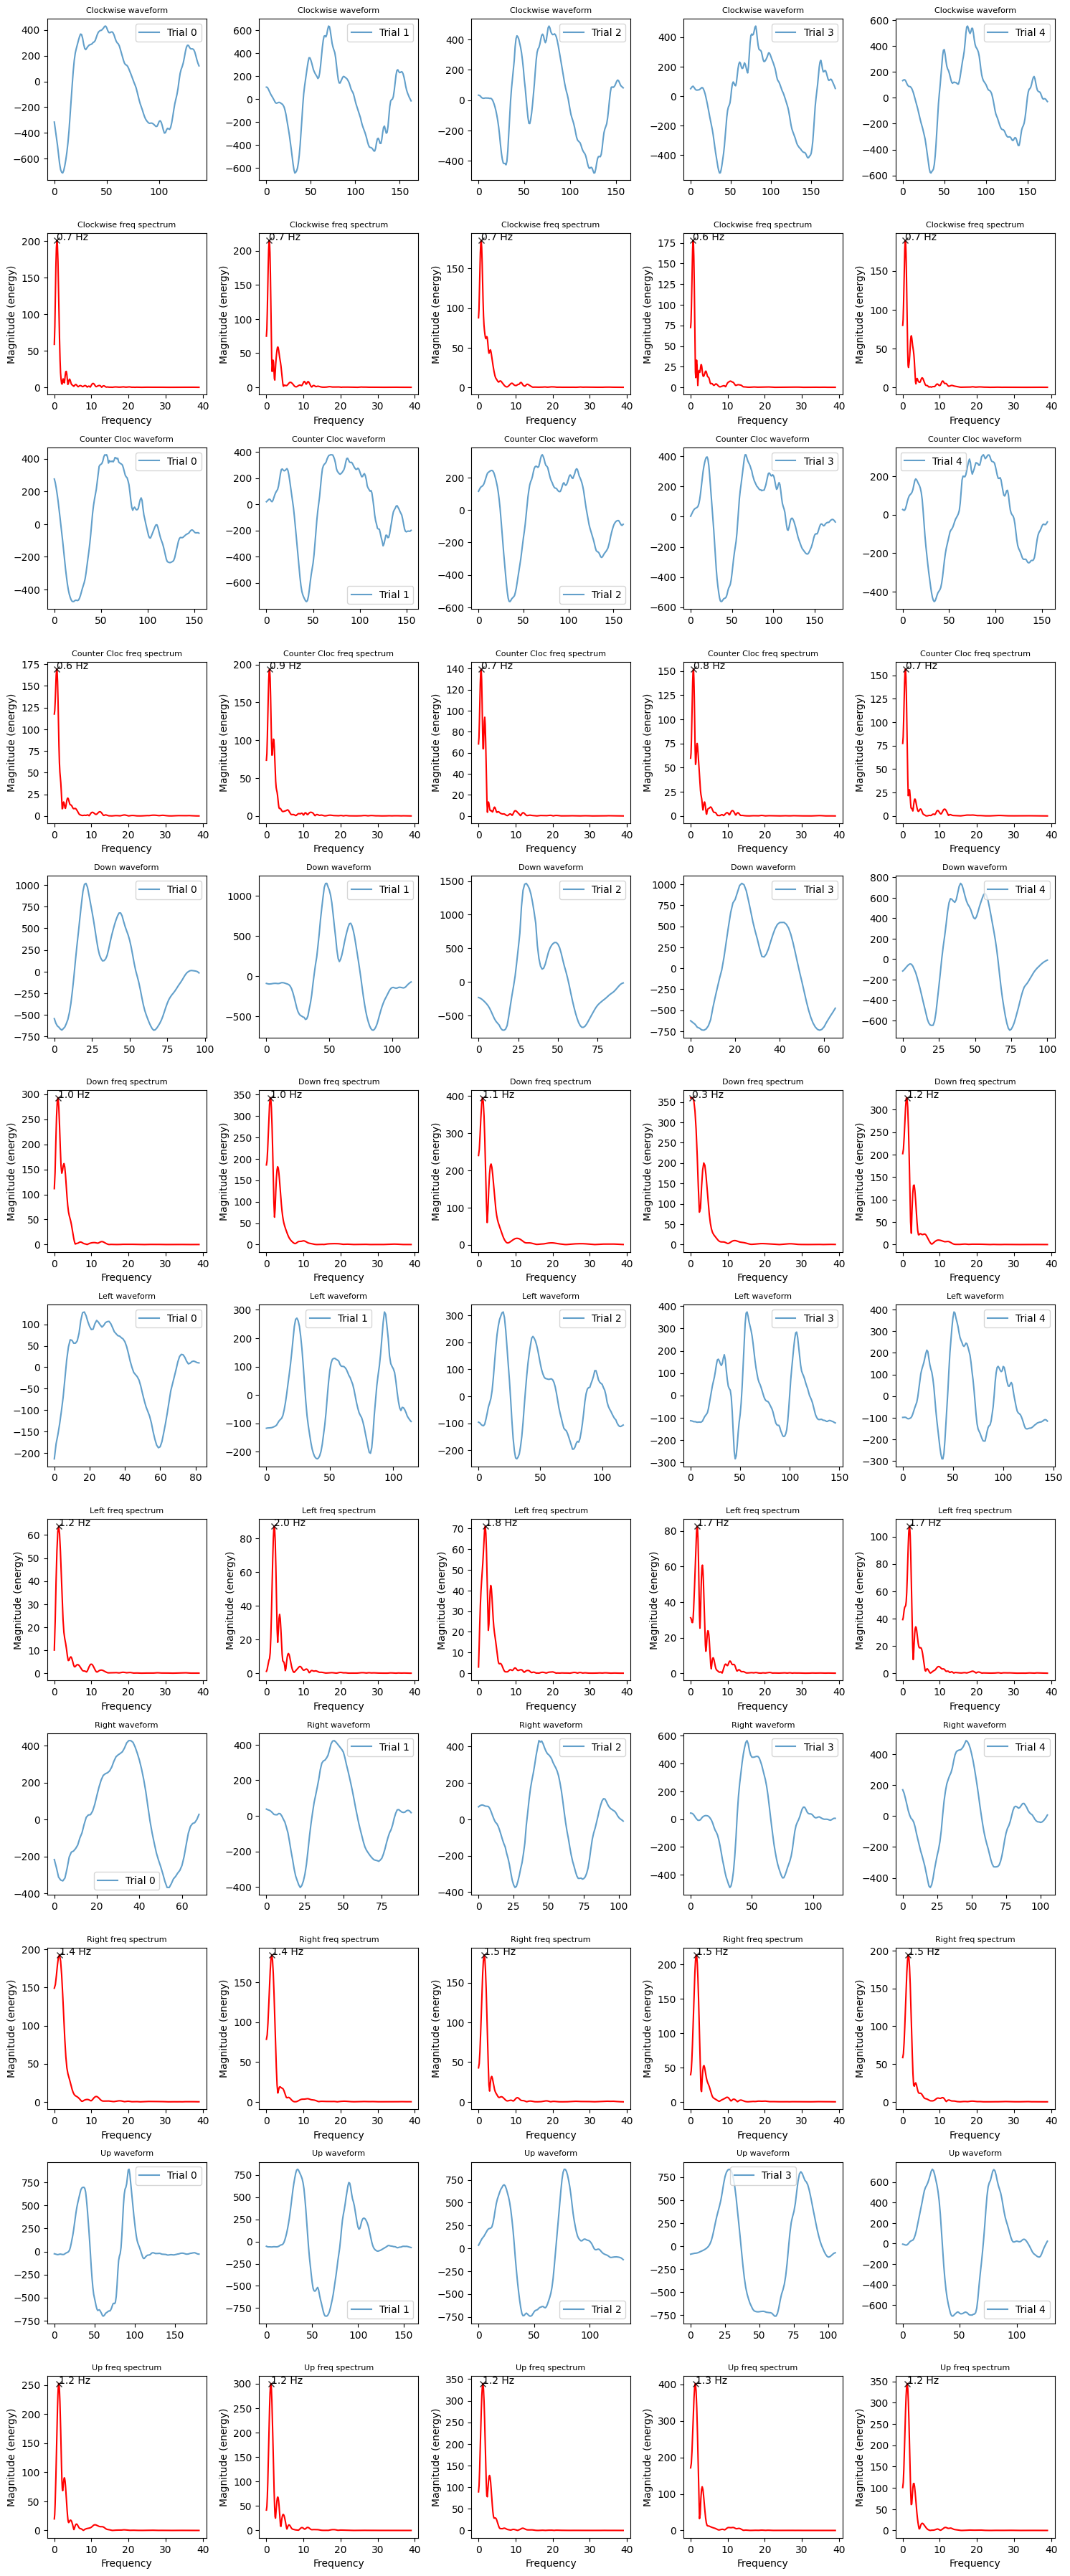

In [14]:
# This cell will take a bit of time not because of the frequency analysis but because
# of preparing the large matplotlib image
import IPython.display as ipd
import ipywidgets

num_cols = 5 # 1 col for each gesture trial 
num_rows = selected_gesture_set.get_num_gestures() * 2 # 1 for waveform, 1 for frequency per gesture
row_height = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, row_height * num_rows))

index = 0
sampling_rate = 92 # roughly 92
progress_bar = ipywidgets.IntProgress(value=0, min=0, max=num_rows)
ipd.display(progress_bar)
title_font_size = 8
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    gesture_trials = selected_gesture_set.get_trials_for_gesture(gesture_name)
    
    for trial in gesture_trials:
        s = trial.accel.mag_p 
        ax = axes[index][trial.trial_num]
        
        s_removed_offset = s - np.mean(s)
        
        ax.plot(s_removed_offset, alpha=0.7, label=f"Trial {trial.trial_num}")
        ax.set_title(f"{gesture_name[0:12]} waveform", fontsize= title_font_size)
        ax.legend()
        
        sampling_rate = math.ceil(trial.accel.sampling_rate)
        ax = axes[index + 1][trial.trial_num]
        spectrum, freqs_of_spectrum, line = ax.magnitude_spectrum(s_removed_offset, Fs = sampling_rate, 
                                                        color='r', pad_to = 4 * len(s))
        ax.set_title(f"{gesture_name[0:12]} freq spectrum", fontsize= title_font_size)
        
        # Annotate the top freq (by amplitude) on each graph
        top_n_freq_with_amplitudes = get_top_n_frequency_peaks(1, freqs_of_spectrum, spectrum)
        top_freq = top_n_freq_with_amplitudes[0][0]
        top_amplitude = top_n_freq_with_amplitudes[0][1]
        ax.plot(top_freq, top_amplitude, marker="x", color="black", alpha=0.8)
        ax.text(top_freq, top_amplitude, f"{top_freq:0.1f} Hz", color="black")
      
    index = index + 2 
    progress_bar.value = index
    
fig.tight_layout(pad=1)

print(f"Selected gesture set: {selected_gesture_set.name}")

6.2.2  Feature: top frequency

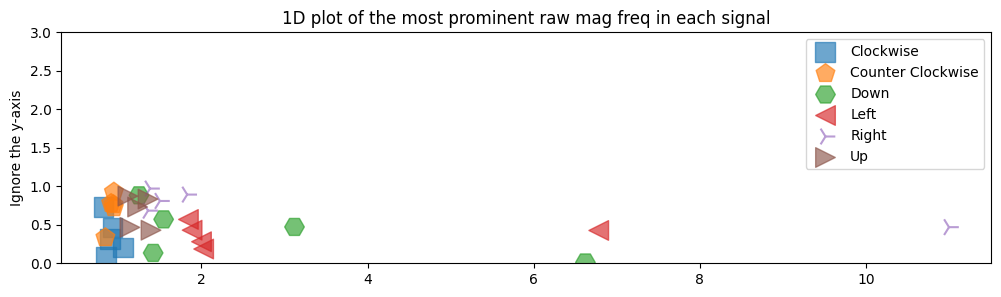

In [15]:
def extract_feature_top_mag_freq(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag, sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(1, fft_freqs, fft_amplitudes)

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return top_n_freq_with_amplitudes[0][0]

plot_feature_1d(selected_gesture_set, extract_feature_top_mag_freq, 
                title = "1D plot of the most prominent raw mag freq in each signal")

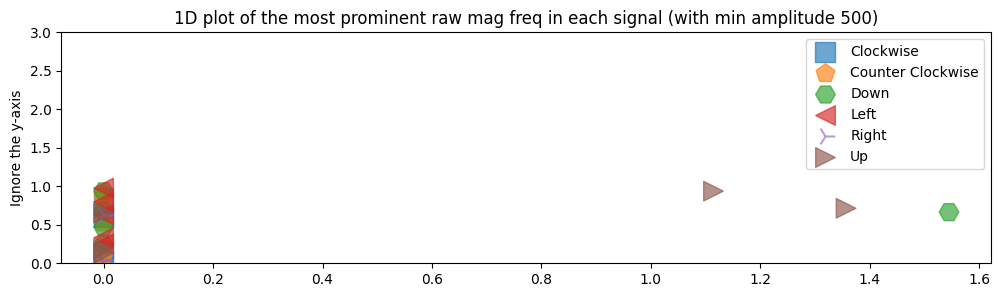

In [16]:
def extract_feature_top_mag_freq2(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag, sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(1, fft_freqs, fft_amplitudes, min_amplitude_threshold = 500)

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return top_n_freq_with_amplitudes[0][0]

plot_feature_1d(selected_gesture_set, extract_feature_top_mag_freq2, 
                title = "1D plot of the most prominent raw mag freq in each signal (with min amplitude 500)")

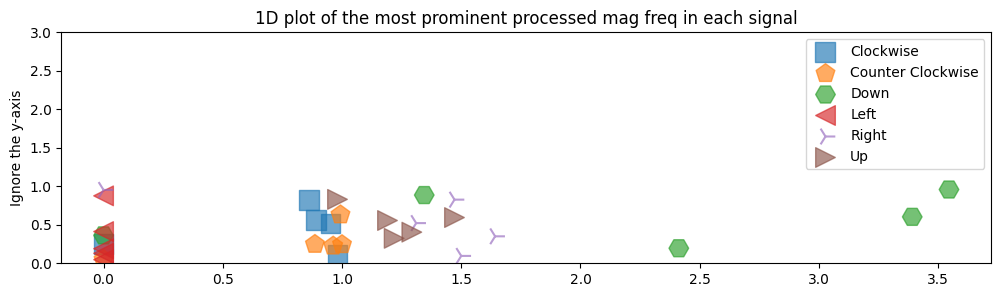

In [17]:
# 1D plot of the most prominent raw mag freq in each signal (with min amplitude 200)
def extract_feature_top_mag_p_freq(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag_p, sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(1, fft_freqs, fft_amplitudes, min_amplitude_threshold = 200)

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return top_n_freq_with_amplitudes[0][0]

plot_feature_1d(selected_gesture_set, extract_feature_top_mag_p_freq, 
                title = "1D plot of the most prominent processed mag freq in each signal")

6.3  2-dimensional explorations

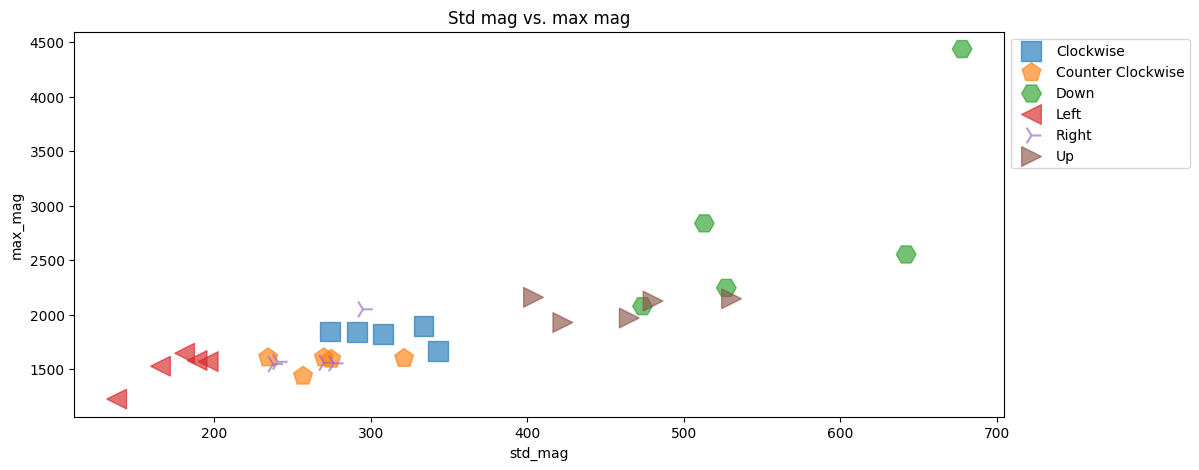

In [18]:
#the standard deviation of the accel mag and the max mag
plot_feature_2d(selected_gesture_set, extract_feature_std_mag, extract_feature_max_mag,
               xlabel="std_mag", ylabel="max_mag", title="Std mag vs. max mag")

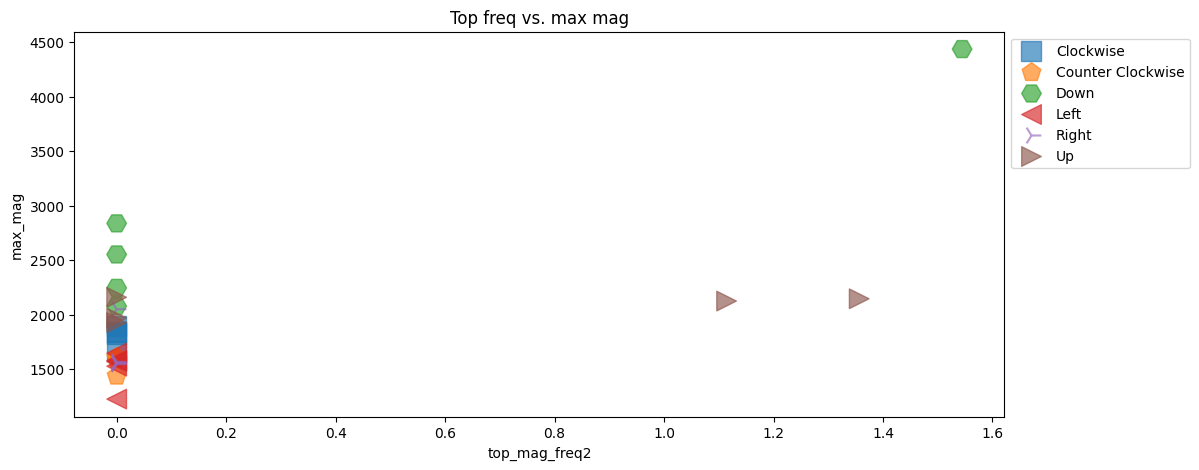

In [19]:
# the max mag frequency component (in frequency domain) and the max mag signal value (in the time domain).
plot_feature_2d(selected_gesture_set, extract_feature_top_mag_freq2, extract_feature_max_mag,
               xlabel="top_mag_freq2", ylabel="max_mag", title="Top freq vs. max mag")

6.4  3-dimensional explorations

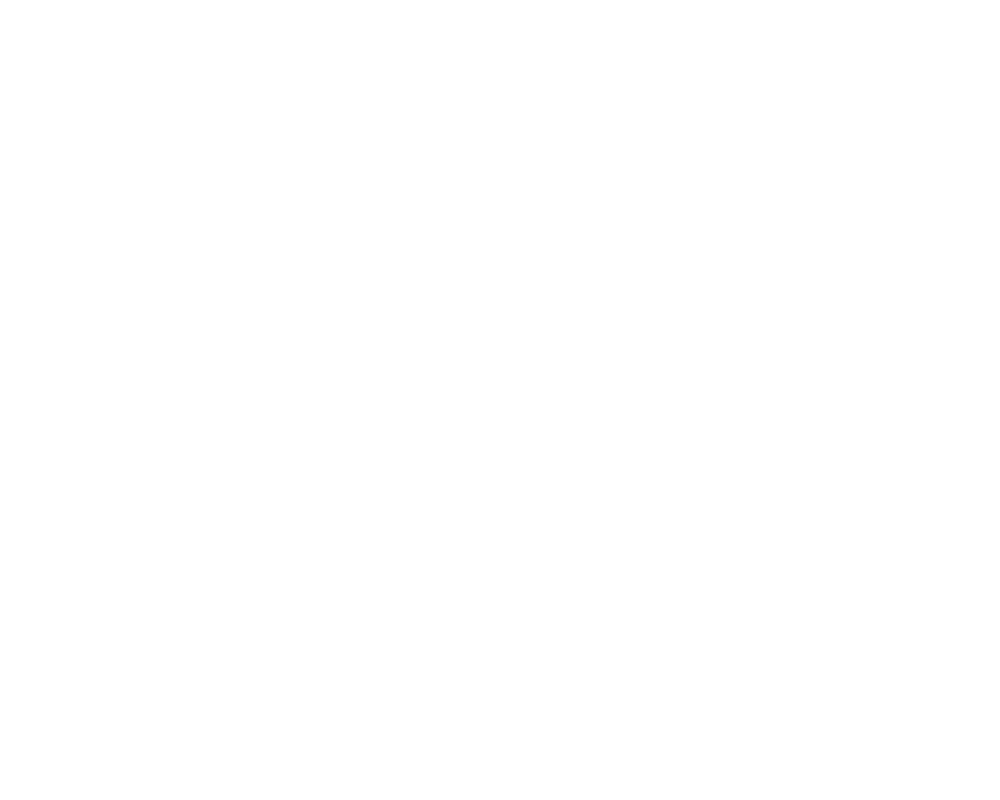

In [26]:
# graphing the highest-amplitude frequency from the magnitude signal, the max magnitude value,
# and the standard deviation of magnitude for each gesture trial (grouped by gesture type)
%matplotlib widget
img = plot_feature_3d(selected_gesture_set, extract_feature_top_mag_freq2, 
                extract_feature_max_mag, extract_feature_std_mag,
                xlabel="top_mag_freq2", ylabel="max_mag", zlabel="std_mag",
                title="Top freq vs. max mag vs. std mag", figsize=(10,8));

6.5  Pandas